# Transfer learning

Das Ziel des Transferlearning ist es, ein bereits trainiertes Modell auf eine andere Aufgabe zu trainieren. Die Idee dahinter ist den Teil des Netzwerks, der für die Extraktion von Merkmalen zuständig ist, zu "recyceln". Da dies in der Regel der teuerste Teil des Trainings ist, spart man sich dadurch eine Menge an Zeit. Das bedeutet, dass dieser Teil nicht neu trainiert werden muss, sondern die bereits trainierte Featurextraktion genauso gut für eine ähnliche Aufgabe verwendet werden kann. Aus diesem Grund sollte man ein bereits trainiertes Netzwerk nutzen, welches für eine ähnliche Aufgabe trainiert wurde. Lediglich die Klassifikationsschicht wird neu trainiert. Ziel dieses Notebooks ist es, ein Verständnis zu bekommen, was beim Transferlearning passiert.

Schauen Sie sich folgendes Notebook an und versuchen Sie den groben Ablauf zu verstehen.
Sie werden die meisten Befehle die Sie benötigen darin finden.
https://www.tensorflow.org/tutorials/images/transfer_learning

Für diese Aufgabe wollen wir das in der letzten Aufgabe trainierte Convolutional Neural Network, welches auf dem Mnist Datensatz trainiert wurde, auf eine andere Aufgabe trainieren. Die Aufgabe des Netzwerks soll es sein, Hexadezimalzahlen zu erkennen.
Hierzu verwenden wir den $\textit{emnist}$ Datensatz. Dieser beinhaltet zusätzlich das Alphabet (große und kleine Buchstaben). Näheres dazu unter https://pypi.org/project/emnist/ 

Gehen Sie dazu wie folgt vor:

    * Laden Sie ihr Modell aus der vorherigen Aufgabe mit tf.keras.models.load_model("Name des Modells") Falls Sie ihr Modell nicht gespeichert hatten, können Sie dies mit model.save("Name des Modells"), nachdem Sie erneut trainiert haben, tun.
      
    * Bereiten Sie den emnist-Datensatz wie in der vorherigen Aufgabe vor und sortieren Sie alle Kleinbuchstaben sowie alle Buchstaben, die nicht der Hexadezimalschreibweise angehören, aus!
      
    * Laden Sie das zuvor gespeicherte Modell und entfernen Sie die letzte Schicht ( model.pop() )
    
    * Frieren Sie das Modell ein, d.h. Sie setzen die Layer auf nicht trainierbar
    
    * Fügen Sie eine neue Schicht hinzu, sodass die verschiedenen Klassen (0-F) klassifiziert werden können (Wir beschränken uns hier auf die groß geschriebenen Buchstaben)
    
    * Trainieren Sie das Netzwerk mit den transformierten Labels
    
    * Plotten Sie wieder die Trainingskurven und erstellen sie eine confusion Matrix

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix 
from extra_keras_datasets import emnist

In [ ]:
from emnist import extract_training_samples, extract_test_samples

# NICK/.cache/emnist/
images_train, labels_train = extract_training_samples('balanced')
images_test, labels_test = extract_test_samples('balanced')

X_train = images_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = images_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = labels_train
y_test = labels_test

# Hexadezimal-Labels: 0–9, 10–15 (A–F)
hex_labels = list(range(10)) + list(range(10, 16))

train_mask = np.isin(y_train, hex_labels)
test_mask = np.isin(y_test, hex_labels)

X_train, y_train = X_train[train_mask], y_train[train_mask]
X_test, y_test = X_test[test_mask], y_test[test_mask]

# Labels auf 0–15 mappen
unique_labels = sorted(np.unique(y_train))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y_train = np.array([label_map[l] for l in y_train])
y_test = np.array([label_map[l] for l in y_test])


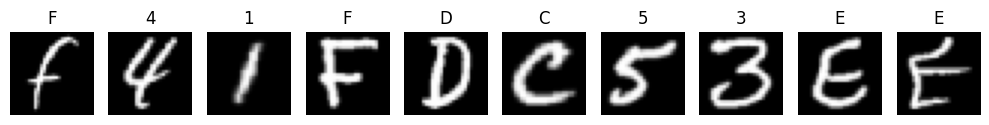

In [39]:
import matplotlib.pyplot as plt

# Plotten Sie hier ein paar Ziffern!

def emnist_id_to_char(label_id):
    if 0 <= label_id <= 9:
        return str(label_id)
    elif 10 <= label_id <= 15:
        return chr(ord('A') + label_id - 10)
    else:
        return "?"  # sollte nicht vorkommen

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(emnist_id_to_char(y_train[i]))
plt.tight_layout()
plt.show()


In [41]:
# Normalisieren Sie das Set und bringen es in die richtige "shape"

from tensorflow.keras.utils import to_categorical

# Normalisieren auf [0, 1]
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Keras CNN braucht shape: (samples, 28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Labels zu One-Hot-Vektoren (für categorical_crossentropy)
Y_train = to_categorical(y_train, num_classes=16)
Y_test = to_categorical(y_test, num_classes=16)



In [42]:
# Laden des Modells
base_model = tf.keras.models.load_model("gpt5.h5")

#Hier die letzte Schicht entfernen
base_model.pop() 

base_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,818 (73.51 KB)

 Trainable params: 18,816 (73.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [43]:

# Modell einfrieren

# Alle Layer des Basismodells einfrieren (nicht trainierbar machen)
for layer in base_model.layers:
    layer.trainable = False
    
# Basismodell als Ausgangspunkt nehmen
inputs = tf.keras.Input(shape=(28, 28,1))
x = base_model(inputs, training=False)

# Hier einen Dense-layer und einmal Softmax hinzufügen, sodass die verschiedenen Klassen vorhergesagt werden! können!
last_layer = tf.keras.layers.Dense(16)(x)    # <- 16 für Hexadezimal: 0-9 und A-F
output     = tf.keras.layers.Activation('softmax')(last_layer)

# Modell Zusammenfügen
model = tf.keras.Model(inputs, output)

In [44]:
# Modell Kompilieren, Kostenfunktion categorical_crossentropy, Optimizer Adam mit der learningrate 1e-4

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 1600)           │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │        25,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,432 (173.56 KB)

 Trainable params: 25,616 (100.06 KB)

 Non-trainable params: 18,816 (73.50 KB)

In [45]:
# Accuracy vor dem Transferlearning bestimmen
loss0, accuracy0 = model.evaluate(x = X_test, y = Y_test)
print("Test-Genauigkeit vor Transfer Learning: {:.2f}%".format(accuracy0*100))

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0597 - loss: 2.7734
Test-Genauigkeit vor Transfer Learning: 6.25%


In [46]:
# Hier das Netzwerk für 10 Epochen trainieren!
history = model.fit(
    X_train, Y_train,
    epochs=10,
    validation_data=(X_test, Y_test)
)

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0616 - loss: 2.7733 - val_accuracy: 0.0625 - val_loss: 2.7726
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0605 - loss: 2.7729 - val_accuracy: 0.0625 - val_loss: 2.7726
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0617 - loss: 2.7728 - val_accuracy: 0.0625 - val_loss: 2.7726
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0620 - loss: 2.7728 - val_accuracy: 0.0625 - val_loss: 2.7726
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0597 - loss: 2.7728 - val_accuracy: 0.0625 - val_loss: 2.7727
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0622 - loss: 2.7729 - val_accuracy: 0.0625 - val_loss: 2.7727
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0604 - loss: 2.7729 - val_accuracy: 0.0625 - val_loss: 2.7726
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0591 - loss: 2.7729 - 

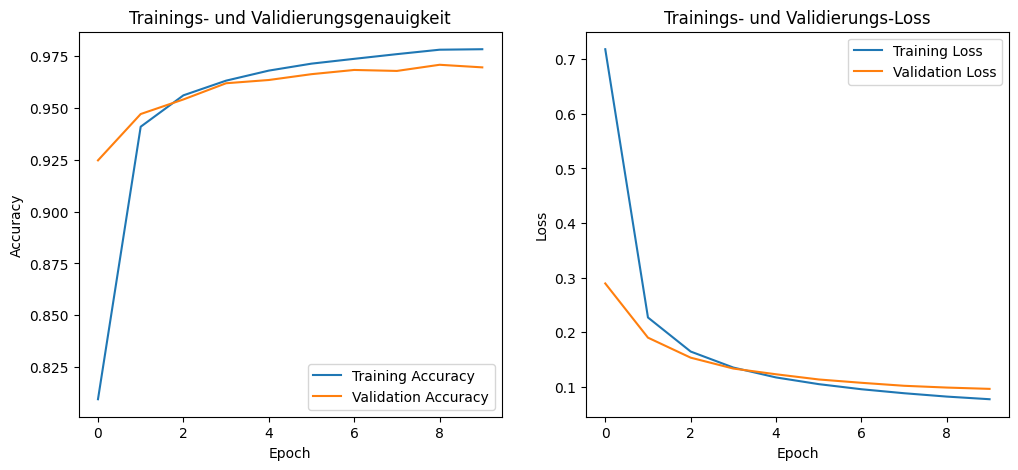

In [32]:
# Plotten der Trainingskurve wie in der Aufgabe zuvor
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Trainings- und Validierungsgenauigkeit')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Trainings- und Validierungs-Loss')
plt.legend()

plt.show()


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


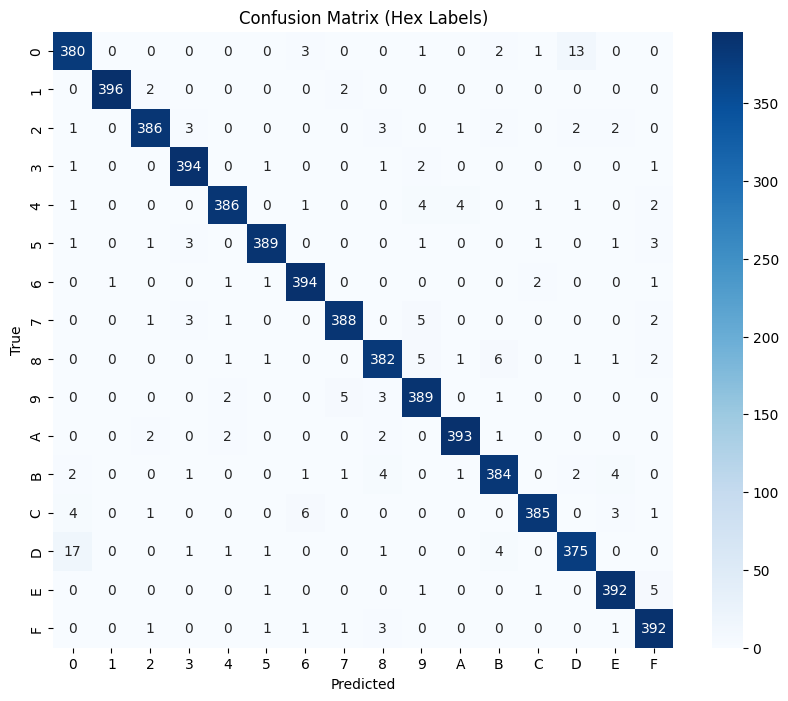

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Deine Hexadezimalzeichen als Liste
hex_labels = list("0123456789ABCDEF")

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=hex_labels, 
    yticklabels=hex_labels
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Hex Labels)')
plt.show()
